In [3]:
"""
Dataset and DataLoader for Masked Image Reconstruction
"""

import torch
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
import numpy as np
from typing import Tuple, Optional, Dict, Any
import matplotlib.pyplot as plt


class MaskedImageDataset(Dataset):
    """画像のマスク再構成用データセット"""

    def __init__(
        self,
        dataset_name: str = "ylecun/mnist",
        split: str = "train",
        mask_ratio: float = 0.5,
        flatten: bool = True,
        normalize: bool = True,
        grayscale: bool = False,
        seed: Optional[int] = None
    ):
        """
        Args:
            dataset_name: データセット名
                - "ylecun/mnist": 28x28 grayscale
                - "uoft-cs/cifar10": 32x32x3 RGB
                - "tanganke/stl10": 96x96x3 RGB
            split: "train" or "test"
            mask_ratio: マスクする割合 (0.0-1.0)
            flatten: 画像を1次元ベクトルにするか
            normalize: 0-1に正規化するか
            grayscale: RGBをグレースケールに変換するか
            seed: 乱数シード（再現性のため）
        """
        self.dataset_name = dataset_name
        self.split = split
        self.mask_ratio = mask_ratio
        self.flatten = flatten
        self.normalize = normalize
        self.grayscale = grayscale

        # データセットをロード
        self.dataset = load_dataset(dataset_name)[split]

        # データセット固有の設定
        self.setup_dataset_config()

        # 画像データを準備
        self.prepare_images()

        # 乱数生成器
        self.rng = np.random.RandomState(seed)

    def setup_dataset_config(self):
        """データセットごとの設定"""
        configs = {
            "ylecun/mnist": {
                "image_key": "image",
                "label_key": "label",
                "image_shape": (28, 28),
                "channels": 1,
                "num_classes": 10
            },
            "uoft-cs/cifar10": {
                "image_key": "img",
                "label_key": "label",
                "image_shape": (32, 32, 3),
                "channels": 3,
                "num_classes": 10
            },
            "tanganke/stl10": {
                "image_key": "image",
                "label_key": "label",
                "image_shape": (96, 96, 3),
                "channels": 3,
                "num_classes": 10
            }
        }

        if self.dataset_name not in configs:
            raise ValueError(f"Unsupported dataset: {self.dataset_name}")

        config = configs[self.dataset_name]
        self.image_key = config["image_key"]
        self.label_key = config["label_key"]
        self.image_shape = config["image_shape"]
        self.channels = config["channels"]
        self.num_classes = config["num_classes"]

        # グレースケール変換の場合、チャンネル数を1に
        if self.grayscale and self.channels == 3:
            self.effective_channels = 1
            self.effective_shape = (self.image_shape[0], self.image_shape[1])
        else:
            self.effective_channels = self.channels
            self.effective_shape = self.image_shape

        # フラット化後の次元
        if self.effective_channels == 1:
            self.flat_dim = self.effective_shape[0] * self.effective_shape[1]
        else:
            self.flat_dim = self.effective_shape[0] * self.effective_shape[1] * self.effective_channels

    def prepare_images(self):
        """画像データの準備"""
        # 画像とラベルを取得
        images = []
        labels = []

        for item in self.dataset:
            img = item[self.image_key]

            # PILイメージまたはnumpy配列をnumpy配列に変換
            if hasattr(img, 'convert'):  # PIL Image
                if self.channels == 1:
                    img = np.array(img.convert('L'))
                else:
                    img = np.array(img.convert('RGB'))
            else:
                img = np.array(img)

            images.append(img)
            labels.append(item[self.label_key])

        self.images = np.array(images, dtype=np.float32)
        self.labels = np.array(labels, dtype=np.int64)

        # 正規化
        if self.normalize:
            self.images = self.images / 255.0

        # グレースケール変換（RGBの場合）
        if self.grayscale and self.channels == 3:
            # RGB to Grayscale: 0.299*R + 0.587*G + 0.114*B
            if len(self.images.shape) == 4:  # (N, H, W, C)
                self.images = np.dot(self.images[..., :3], [0.299, 0.587, 0.114])
                self.images = self.images[:, :, :, np.newaxis]  # (N, H, W, 1)
            elif len(self.images.shape) == 3:  # MNISTなど、既にグレースケール
                self.images = self.images[:, :, :, np.newaxis]
        elif self.channels == 1 and len(self.images.shape) == 3:
            # MNISTなど、元々グレースケールの場合
            self.images = self.images[:, :, :, np.newaxis]

        print(f"Loaded {len(self.images)} images from {self.dataset_name}/{self.split}")
        print(f"Original shape: {self.image_shape}, Channels: {self.channels}")
        if self.grayscale and self.channels == 3:
            print(f"Converted to grayscale")
        print(f"Effective shape: {self.images[0].shape}")
        print(f"Flattened dim: {self.flat_dim}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, int]:
        """
        Returns:
            masked_image: マスクされた画像
            original_image: 元の画像
            mask: マスク (1=visible, 0=masked)
            label: ラベル
        """
        # 画像とラベルを取得
        image = self.images[idx].copy()
        label = self.labels[idx]

        # Tensorに変換
        image = torch.from_numpy(image).float()

        # フラット化
        if self.flatten:
            image = image.reshape(-1)

        # ピクセル単位でマスクを生成
        if self.flatten:
            if self.effective_channels == 1:
                # グレースケール：そのままマスク
                mask = torch.rand(self.flat_dim) > self.mask_ratio
            else:
                # RGB：ピクセル単位でマスクして全チャンネルに適用
                num_pixels = self.flat_dim // self.effective_channels
                pixel_mask = torch.rand(num_pixels) > self.mask_ratio
                mask = pixel_mask.repeat_interleave(self.effective_channels)
        else:
            # フラット化しない場合（H, W, C）
            if self.effective_channels == 1:
                h, w = self.effective_shape[:2]
                mask = torch.rand(h, w, 1) > self.mask_ratio
            else:
                h, w = self.effective_shape[:2]
                pixel_mask = torch.rand(h, w, 1) > self.mask_ratio
                mask = pixel_mask.repeat(1, 1, self.effective_channels)

        mask = mask.float()

        # マスクを適用
        masked_image = image * mask

        return masked_image, image, mask, label


def create_dataloader(
    dataset_name: str = "ylecun/mnist",
    batch_size: int = 32,
    mask_ratio: float = 0.5,
    flatten: bool = True,
    normalize: bool = True,
    grayscale: bool = False,
    num_workers: int = 2,
    pin_memory: bool = True,
    seed: Optional[int] = None
) -> Tuple[DataLoader, DataLoader, int]:
    """
    DataLoaderを作成

    Args:
        dataset_name: データセット名
        batch_size: バッチサイズ
        mask_ratio: マスク割合
        flatten: 1次元化するか
        normalize: 正規化するか
        grayscale: RGBをグレースケールに変換するか
        num_workers: DataLoaderのワーカー数
        pin_memory: GPUメモリにピン留めするか
        seed: 乱数シード

    Returns:
        train_loader: 訓練用DataLoader
        test_loader: テスト用DataLoader
        input_dim: 入力次元
    """
    # 訓練データセット
    train_dataset = MaskedImageDataset(
        dataset_name=dataset_name,
        split="train",
        mask_ratio=mask_ratio,
        flatten=flatten,
        normalize=normalize,
        grayscale=grayscale,
        seed=seed
    )

    # テストデータセット
    test_dataset = MaskedImageDataset(
        dataset_name=dataset_name,
        split="test",
        mask_ratio=mask_ratio,
        flatten=flatten,
        normalize=normalize,
        grayscale=grayscale,
        seed=seed
    )

    # DataLoader作成
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_memory
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory
    )

    # 入力次元を返す
    input_dim = train_dataset.flat_dim if flatten else train_dataset.effective_shape

    return train_loader, test_loader, input_dim


def visualize_masked_images(
    dataloader: DataLoader,
    num_samples: int = 8,
    figsize: Tuple[int, int] = (16, 8),
    save_path: Optional[str] = None
):
    """
    マスクされた画像と元の画像を並べて表示

    Args:
        dataloader: DataLoader
        num_samples: 表示するサンプル数
        figsize: 図のサイズ
        save_path: 保存先パス（Noneの場合は表示のみ）
    """
    # 1バッチ取得
    masked_images, original_images, masks, labels = next(iter(dataloader))

    # 表示するサンプル数を調整
    num_samples = min(num_samples, len(masked_images))

    # データセットの情報を取得
    dataset = dataloader.dataset
    is_grayscale = dataset.effective_channels == 1
    image_shape = dataset.effective_shape

    # フラット化されている場合は元の形状に戻す
    if dataset.flatten:
        if is_grayscale:
            h, w = image_shape
            masked_images = masked_images[:num_samples].reshape(num_samples, h, w)
            original_images = original_images[:num_samples].reshape(num_samples, h, w)
            masks = masks[:num_samples].reshape(num_samples, h, w)
        else:
            h, w, c = image_shape
            masked_images = masked_images[:num_samples].reshape(num_samples, h, w, c)
            original_images = original_images[:num_samples].reshape(num_samples, h, w, c)
            masks = masks[:num_samples].reshape(num_samples, h, w, c)
            # マスクは各チャンネル同じなので1チャンネルだけ取る
            masks = masks[:, :, :, 0]
    else:
        masked_images = masked_images[:num_samples].squeeze()
        original_images = original_images[:num_samples].squeeze()
        masks = masks[:num_samples].squeeze()

        # カラー画像の場合、マスクを1チャンネルに
        if len(masks.shape) == 4:
            masks = masks[:, :, :, 0]

    # numpy配列に変換
    masked_images = masked_images.cpu().numpy()
    original_images = original_images.cpu().numpy()
    masks = masks.cpu().numpy()
    labels = labels[:num_samples].cpu().numpy()

    # 図を作成（3列：元画像、マスク、マスク後画像）
    fig, axes = plt.subplots(num_samples, 3, figsize=figsize)

    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i in range(num_samples):
        # 元の画像
        ax = axes[i, 0]
        if is_grayscale:
            ax.imshow(original_images[i], cmap='gray', vmin=0, vmax=1)
        else:
            ax.imshow(original_images[i], vmin=0, vmax=1)
        ax.set_title(f'Original (Label: {labels[i]})')
        ax.axis('off')

        # マスク
        ax = axes[i, 1]
        ax.imshow(masks[i], cmap='binary', vmin=0, vmax=1)
        mask_ratio = 1 - masks[i].mean()
        ax.set_title(f'Mask ({mask_ratio:.1%} masked)')
        ax.axis('off')

        # マスクされた画像
        ax = axes[i, 2]
        if is_grayscale:
            ax.imshow(masked_images[i], cmap='gray', vmin=0, vmax=1)
        else:
            ax.imshow(masked_images[i], vmin=0, vmax=1)
        ax.set_title('Masked Image')
        ax.axis('off')

    # タイトル
    dataset_name = dataset.dataset_name.split('/')[-1].upper()
    fig.suptitle(f'{dataset_name} - Masked Image Reconstruction Task', fontsize=16)

    plt.tight_layout()

    # 保存または表示
    if save_path:
        plt.savefig(save_path, dpi=100, bbox_inches='tight')
        print(f"Saved visualization to {save_path}")
    else:
        plt.show()

    return fig


def visualize_reconstruction(
    model,
    dataloader: DataLoader,
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu',
    num_samples: int = 8,
    figsize: Tuple[int, int] = (20, 10),
    save_path: Optional[str] = None
):
    """
    モデルの再構成結果を可視化

    Args:
        model: 学習済みモデル
        dataloader: DataLoader
        device: デバイス
        num_samples: 表示するサンプル数
        figsize: 図のサイズ
        save_path: 保存先パス
    """
    model.eval()

    # 1バッチ取得
    masked_images, original_images, masks, labels = next(iter(dataloader))

    # 表示するサンプル数を調整
    num_samples = min(num_samples, len(masked_images))

    # モデルで予測
    with torch.no_grad():
        masked_images_device = masked_images[:num_samples].to(device)
        reconstructed = model(masked_images_device).cpu()

    # データセットの情報を取得
    dataset = dataloader.dataset
    is_grayscale = dataset.effective_channels == 1
    image_shape = dataset.effective_shape

    # フラット化されている場合は元の形状に戻す
    if dataset.flatten:
        if is_grayscale:
            h, w = image_shape
            masked_images = masked_images[:num_samples].reshape(num_samples, h, w)
            original_images = original_images[:num_samples].reshape(num_samples, h, w)
            reconstructed = reconstructed.reshape(num_samples, h, w)
            masks = masks[:num_samples].reshape(num_samples, h, w)
        else:
            h, w, c = image_shape
            masked_images = masked_images[:num_samples].reshape(num_samples, h, w, c)
            original_images = original_images[:num_samples].reshape(num_samples, h, w, c)
            reconstructed = reconstructed.reshape(num_samples, h, w, c)
            masks = masks[:num_samples].reshape(num_samples, h, w, c)
            masks = masks[:, :, :, 0]
    else:
        masked_images = masked_images[:num_samples].squeeze()
        original_images = original_images[:num_samples].squeeze()
        reconstructed = reconstructed.squeeze()
        masks = masks[:num_samples].squeeze()
        if len(masks.shape) == 4:
            masks = masks[:, :, :, 0]

    # numpy配列に変換
    masked_images = masked_images.cpu().numpy()
    original_images = original_images.cpu().numpy()
    reconstructed = reconstructed.numpy()
    masks = masks.cpu().numpy()
    labels = labels[:num_samples].cpu().numpy()

    # 図を作成（4列：元画像、マスク、マスク後画像、再構成画像）
    fig, axes = plt.subplots(num_samples, 4, figsize=figsize)

    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i in range(num_samples):
        # 元の画像
        ax = axes[i, 0]
        if is_grayscale:
            ax.imshow(original_images[i], cmap='gray', vmin=0, vmax=1)
        else:
            ax.imshow(original_images[i], vmin=0, vmax=1)
        ax.set_title(f'Original (Label: {labels[i]})')
        ax.axis('off')

        # マスク
        ax = axes[i, 1]
        ax.imshow(masks[i], cmap='binary', vmin=0, vmax=1)
        mask_ratio = 1 - masks[i].mean()
        ax.set_title(f'Mask ({mask_ratio:.1%})')
        ax.axis('off')

        # マスクされた画像
        ax = axes[i, 2]
        if is_grayscale:
            ax.imshow(masked_images[i], cmap='gray', vmin=0, vmax=1)
        else:
            ax.imshow(masked_images[i], vmin=0, vmax=1)
        ax.set_title('Masked')
        ax.axis('off')

        # 再構成画像
        ax = axes[i, 3]
        if is_grayscale:
            ax.imshow(reconstructed[i], cmap='gray', vmin=0, vmax=1)
        else:
            ax.imshow(np.clip(reconstructed[i], 0, 1), vmin=0, vmax=1)

        # 再構成誤差（マスク部分のみ）
        mse = ((original_images[i] - reconstructed[i]) ** 2 * (1 - masks[i])).mean()
        ax.set_title(f'Reconstructed (MSE: {mse:.4f})')
        ax.axis('off')

    # タイトル
    dataset_name = dataset.dataset_name.split('/')[-1].upper()
    fig.suptitle(f'{dataset_name} - Reconstruction Results', fontsize=16)

    plt.tight_layout()

    # 保存または表示
    if save_path:
        plt.savefig(save_path, dpi=100, bbox_inches='tight')
        print(f"Saved reconstruction to {save_path}")
    else:
        plt.show()

    return fig



Testing MNIST...
Loaded 60000 images from ylecun/mnist/train
Original shape: (28, 28), Channels: 1
Effective shape: (28, 28, 1)
Flattened dim: 784
Loaded 10000 images from ylecun/mnist/test
Original shape: (28, 28), Channels: 1
Effective shape: (28, 28, 1)
Flattened dim: 784
Masked images shape: torch.Size([10, 784])
Original images shape: torch.Size([10, 784])
Masks shape: torch.Size([10, 784])
Labels shape: torch.Size([10])
Mask ratio (actual): 0.80

Input dimension: 784

Visualizing masked images...


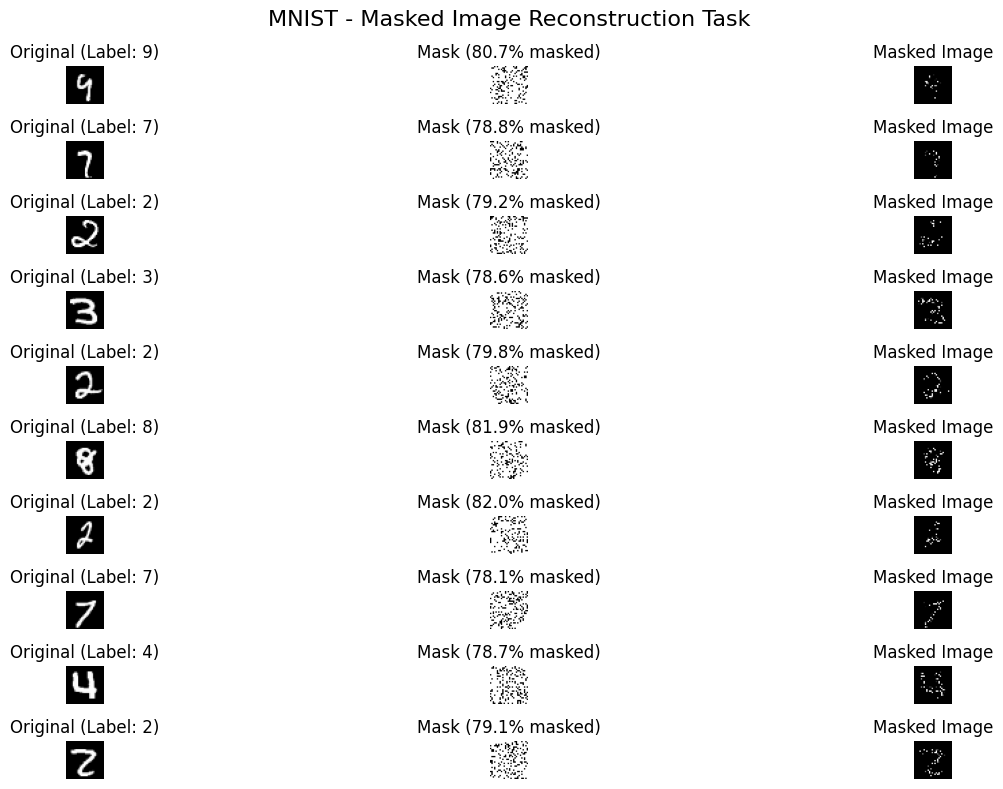

In [8]:
# # テスト用コード
# if __name__ == "__main__":
#     # MNIST
#     print("Testing MNIST...")
#     train_loader, test_loader, input_dim = create_dataloader(
#         dataset_name="ylecun/mnist",
#         batch_size=10,
#         mask_ratio=0.80
#     )

#     # 1バッチ取得してテスト
#     for masked_images, original_images, masks, labels in train_loader:
#         print(f"Masked images shape: {masked_images.shape}")
#         print(f"Original images shape: {original_images.shape}")
#         print(f"Masks shape: {masks.shape}")
#         print(f"Labels shape: {labels.shape}")
#         print(f"Mask ratio (actual): {(masks == 0).float().mean():.2f}")
#         break

#     print(f"\nInput dimension: {input_dim}")

#     # 可視化テスト
#     print("\nVisualizing masked images...")
#     visualize_masked_images(train_loader, num_samples=10)